In [1]:
url = "https://raw.githubusercontent.com/siddley1001/Resume_Extraction/main/Resume.json"


import pandas as pd
import numpy as np
import spacy as sp
import os
from collections import defaultdict
import matplotlib.pyplot as plt

import json
import requests

path = '/content/Resume.json'
data = [json.loads(line) for line in open(path, 'r')]

In [10]:
def pop_annot(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']

        for c_lab in labels:
            if len(c_lab['label']) > 0:
                in_line[c_lab['label'][0]] += c_lab['points']
    return in_line

def extract_highlights(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label']) > 0:
                in_line['highlight'] += [dict(category = c_lab['label'][0], **cpts) for cpts in c_lab['points']]
    return in_line

def result_to_vec(in_row, focus_col):
    let_vec = in_row['kosher_content']
    attn_vec = np.zeros((len(let_vec)))

    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        attn_vec[s:e+1] = 1.0
    return let_vec, attn_vec

In [3]:
with open(path, 'r') as f:
    #parse the data line-by-line
    resume_data = [json.loads(file_line) for file_line in f.readlines()]
    resume_df = pd.DataFrame([pop_annot(line) for line in resume_data])

resume_df['length'] = resume_df['content'].map(len)

resume_df.sample(3)

,content,annotation,Companies worked at,Skills,Graduation Year,College Name,Degree,Designation,Email Address,Location,Name,Years of Experience,UNKNOWN,length
63,Sivaganesh Selvakumar\nDevOps Consultant with ...,"[{'label': ['Skills'], 'points': [{'start': 23...","[{'start': 1915, 'end': 1930, 'text': 'Infosys...","[{'start': 2349, 'end': 2641, 'text': 'TECHNIC...",NaN,"[{'start': 2257, 'end': 2290, 'text': 'Saranat...","[{'start': 1990, 'end': 2043, 'text': 'Bachelo...","[{'start': 1895, 'end': 1912, 'text': 'Technol...",NaN,"[{'start': 1934, 'end': 1940, 'text': 'Chennai...","[{'start': 0, 'end': 20, 'text': 'Sivaganesh S...",NaN,NaN,2642
59,Sharan Adla\n- Email me on Indeed: indeed.com/...,"[{'label': ['College Name'], 'points': [{'star...",NaN,NaN,NaN,"[{'start': 2421, 'end': 2449, 'text': 'Vignan ...","[{'start': 2416, 'end': 2418, 'text': 'SSC'}, ...","[{'start': 1092, 'end': 1115, 'text': 'Special...","[{'start': 1801, 'end': 1841, 'text': 'indeed....",NaN,"[{'start': 0, 'end': 10, 'text': 'Sharan Adla'}]","[{'start': 86, 'end': 90, 'text': '4yrs.'}]",NaN,2633
64,"Snehal Jadhav\nMumbai, Maharashtra - Email me ...","[{'label': ['Companies worked at'], 'points': ...","[{'start': 1794, 'end': 1799, 'text': 'Cisco '...","[{'start': 415, 'end': 1909, 'text': 'Architec...",NaN,"[{'start': 387, 'end': 404, 'text': 'Shivaji U...","[{'start': 347, 'end': 384, 'text': 'B.E in El...","[{'start': 118, 'end': 137, 'text': 'L1 networ...","[{'start': 1077, 'end': 1119, 'text': 'indeed....","[{'start': 148, 'end': 153, 'text': 'Mumbai'},...","[{'start': 0, 'end': 13, 'text': 'Snehal Jadha...",NaN,NaN,1910


Text(0.5, 1.0, 'Length of Resumes (in characters)')

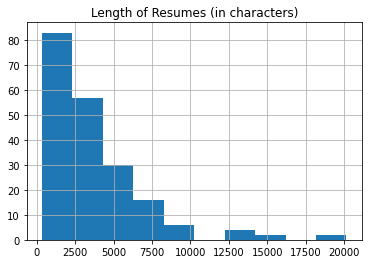

In [4]:
resume_df['length'].hist()
plt.title('Length of Resumes (in words)')

In [5]:
resume_hl_df = pd.DataFrame([extract_highlights(line) for line in resume_data])
resume_hl_df['length'] = resume_hl_df['content'].map(len)
resume_hl_df.sample(3)

,content,annotation,highlight,length
68,"Srabani Das\nsoftware engineer - Oracle, Busin...","[{'label': ['Companies worked at'], 'points': ...","[{'category': 'Companies worked at', 'start': ...",5044
63,Sivaganesh Selvakumar\nDevOps Consultant with ...,"[{'label': ['Skills'], 'points': [{'start': 23...","[{'category': 'Skills', 'start': 2349, 'end': ...",2642
13,Kavya U.\nNetwork Ops Associate - Accenture\n\...,"[{'label': ['Skills'], 'points': [{'start': 18...","[{'category': 'Skills', 'start': 1844, 'end': ...",1873


Text(0.5, 1.0, 'Length of Resumes (in characters)')

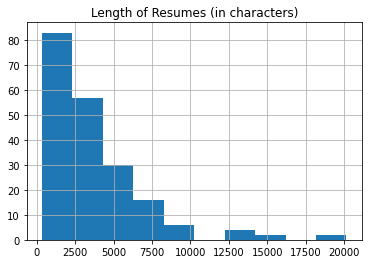

In [6]:
resume_hl_df['length'].hist()
plt.title('Length of Resumes (in words)')

In [8]:
from string import ascii_lowercase, digits

valid_chars = ascii_lowercase + digits + '@., '
focus_col = 'highlight'
focus_df = resume_hl_df[['content', focus_col, 'length']].copy().dropna()

#clean text but maintain the length
focus_df['kosher_content'] = resume_df['content'].str.lower().map(lambda c_text: ''.join([c if c in valid_chars else " " for c in c_text]))

print(focus_col, 'with', focus_df.shape[0], 'complete results')

highlight with 200 complete results


In [9]:
print('First result')
for _, c_row in focus_df.query('length < 2000').sample(1, random_state=20).iterrows():
    print(len(c_row['content']))
    for yoe in c_row[focus_col]:
        s,e = yoe['start'], yoe['end']
        print(yoe)
        print(c_row['content'][s:e+1])

First result
1318
{'category': 'Email Address', 'start': 1234, 'end': 1276, 'text': 'indeed.com/r/Gunjan-Nayyar/a5819ca6733a0f41'}
indeed.com/r/Gunjan-Nayyar/a5819ca6733a0f41
{'category': 'Graduation Year', 'start': 1146, 'end': 1149, 'text': '2018'}
2018
{'category': 'College Name', 'start': 1117, 'end': 1136, 'text': 'Chitkara University\n'}
Chitkara University

{'category': 'Degree', 'start': 1103, 'end': 1115, 'text': 'B. E. in CSE\n'}
B. E. in CSE

{'category': 'Designation', 'start': 417, 'end': 459, 'text': 'Member of Discipline Committee in ALGORYTHM'}
Member of Discipline Committee in ALGORYTHM
{'category': 'Designation', 'start': 276, 'end': 318, 'text': 'Member of Discipline Committee in ALGORYTHM'}
Member of Discipline Committee in ALGORYTHM
{'category': 'Companies worked at', 'start': 267, 'end': 273, 'text': 'INFOSYS'}
INFOSYS
{'category': 'Companies worked at', 'start': 258, 'end': 264, 'text': 'INFOSYS'}
INFOSYS
{'category': 'Years of Experience', 'start': 235, 'end': 2

In [15]:
focus_df.head()

,content,highlight,length,kosher_content
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'category': 'Companies worked at', 'start': ...",1845,govardhana k senior software engineer bengalu...
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'category': 'Companies worked at', 'start': ...",5203,"harini komaravelli test analyst at oracle, hyd..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'category': 'Skills', 'start': 2246, 'end': ...",2573,hartej kathuria data analyst intern oracle r...
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'category': 'Skills', 'start': 4652, 'end': ...",4850,ijas nizamuddin associate consultant state s...
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'category': 'Skills', 'start': 1894, 'end': ...",2173,"imgeeyaul ansari java developer pune, maharas..."


In [16]:
focus_df.iloc[0,3]

'govardhana k senior software engineer  bengaluru, karnataka, karnataka   email me on indeed  indeed.com r govardhana k  b2de315d95905b68  total it experience 5 years 6 months cloud lending solutions inc 4 month   salesforce developer oracle 5 years 2 month   core java developer languages core java, go lang oracle pl sql programming, sales force developer with apex.  designations   promotions  willing to relocate  anywhere  work experience  senior software engineer  cloud lending solutions    bangalore, karnataka    january 2018 to present  present  senior consultant  oracle    bangalore, karnataka    november 2016 to december 2017  staff consultant  oracle    bangalore, karnataka    january 2014 to october 2016  associate consultant  oracle    bangalore, karnataka    november 2012 to december 2013  education  b.e in computer science engineering  adithya institute of technology    tamil nadu  september 2008 to june 2012  https   www.indeed.com r govardhana k b2de315d95905b68 isid rex d

In [20]:
focus_df.loc[0, 'content']

'Govardhana K\nSenior Software Engineer\n\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\nb2de315d95905b68\n\nTotal IT experience 5 Years 6 Months\nCloud Lending Solutions INC 4 Month • Salesforce Developer\nOracle 5 Years 2 Month • Core Java Developer\nLanguages Core Java, Go Lang\nOracle PL-SQL programming,\nSales Force Developer with APEX.\n\nDesignations & Promotions\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Software Engineer\n\nCloud Lending Solutions -  Bangalore, Karnataka -\n\nJanuary 2018 to Present\n\nPresent\n\nSenior Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2016 to December 2017\n\nStaff Consultant\n\nOracle -  Bangalore, Karnataka -\n\nJanuary 2014 to October 2016\n\nAssociate Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2012 to December 2013\n\nEDUCATION\n\nB.E in Computer Science Engineering\n\nAdithya Institute of Technology -  Tamil Nadu\n\nSeptember 2008 to June 2012\n\nhttps://www.

Individuals have many entries in the dictionary:

* label: what the *record* will describe
        - Companies worked at
        - Skills
        - Graduation Year
        - College Name
        - Degree
        - Designation
        - Email Address
        - Location

*   points
        - start
        - end
        - text

*   For each individual create a dictionary that:
        -  Each Company 
            - Duration
        -  Skills 
        -  Positions [List]
        - College
            - Graduation Year
            - Major
            - Location 




